## Supernova cadence metric

This metric is an estimate of the redshift limit z of a faint [(x1,color) = (-2.0,0.2)] supernovae. Depending on Signal-to-Noise thresholds (defined by the user), mean cadences and mean five-sigma depth values (from simulation), z is corresponding to the detection limit. This metric reflects cadences and m5 dependencies on supernova detection.
### Input parameters
- band
- Signal-To-Noise ratio (SNR per band): use as detection thresholds (typical values given below)
- mag_range: magnitude range considered
- dt_range : cadence range (in days-1) for the study
- zmin, zmax: min and mad redshifts for the study
- Li_files : list of npy files with light curves
- mag_to_flux : list of npy files with mag to flux conversion

This metric may be run yearly, per season or using the complete survey.


## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snCadenceMetric import SNCadenceMetric
from lsst.sims.maf.utils.snUtils import Lims

## DB file choice

In [2]:
#dbName = 'kraken_2026.db'
#dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
dbName = 'kraken_2026.db'
dbFile = dbName
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
#propinfo, proptags = opsimdb.fetchPropInfo()
#print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

## Field choice (DD or WFD)

In [3]:
fieldtype='WFD' #fieldtype: DD or WFD

sqlconstraint = '' #opsimdb.createSQLWhere(fieldtype, proptags)


if fieldtype == 'DD':
    SNR = dict(zip('griz', [25., 25., 30., 35.]))  # SNR for DD
    mag_range = [23., 27.5]  # DD mag range
    dt_range = [0.5, 25.]  # DD dt range
    coadd = True
    zmin = 0.4
    zmax = 0.7
if fieldtype == 'WFD':
    SNR = dict(zip('griz', [30., 40., 30., 20.]))  # SNR for WFD
    mag_range = [21., 25.5]  # WFD mag range
    dt_range = [0.5, 30.]  # WFD dt range
    coadd = False
    zmin = 0.1
    zmax = 0.6
    
Li_files = ['../../data/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../../data/Mag_to_Flux_SNCosmo.npy']

In [4]:
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))
bands = 'r'
    # for i, band in enumerate(SNR.keys()):
plotDict = {'title': 'Redshift limit',
                'xlabel': 'z','xMin':zmin,'xMax':zmax,'nTicks':10,
           'colorMin': zmin,'colorMax':zmax}

plotDict['bins'] = np.arange(0.,0.5,0.05)

print(yearDates)
yearDates = yearDates[:5]

# Load sn lc info and mags
lim_sn = {}
for band in bands:
     lim_sn[band] = Lims(Li_files, mag_to_flux_files, band, SNR[band],
                          mag_range=mag_range, dt_range=dt_range)

[0, 365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650]


## Define slicer

In [5]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make the bundles

### Run for selected years

In [6]:
bundleList= []
for band in bands: #Loop on the bands
    sql_i = '' #sqlconstraint+' AND '
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
    
    metric = SNCadenceMetric(lim_sn=lim_sn[band], coadd=coadd)
    
    for i in range(len(yearDates) - 1):
        sql_y = sql_i + \
            ' AND night > %i AND night <= %i' % (
                yearDates[i], yearDates[i + 1]) #sql constraint on the year
        plotDict['title'] = 'Y{} - {} band'.format(i+1,band)
            
        bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_y, runName= dbName,plotDict=plotDict))
print(len(bundleList))

4


### Run over the complete sample

In [7]:
bundleList= []
for band in bands: #Loop on the bands
    sql_i = '' #sqlconstraint+' AND '
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
    
    metric = SNCadenceMetric(lim_sn=lim_sn[band], coadd=coadd)
    
    plotDict['title'] = '{} band'.format(band)
            
    bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_i, runName= dbName,plotDict=plotDict))
print(len(bundleList))

1


In [8]:
outDir = '{}_Cadence'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['night', 'numExposures', 'observationId', 'visitTime', 'visitExposureTime', 'filter', 'observationStartMJD', 'fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 532326 visits
Running:  ['kraken_2026_db_SNCadenceMetric_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "filter = "r"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_2_8_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_2_8_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_2_8_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0
/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_2_8_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6

monopole: 0.257357  dipole: lon: -162.829, lat: -78.9613, amp: 0.0351835
Plotting complete.


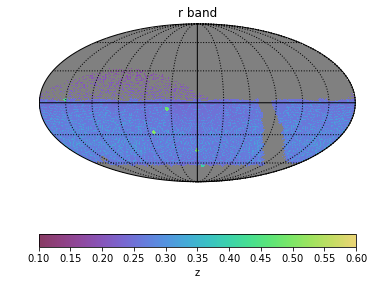

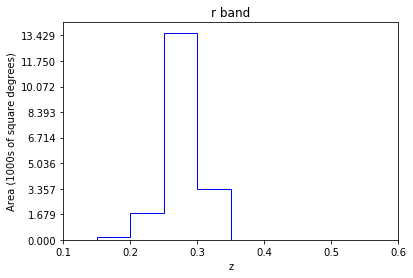

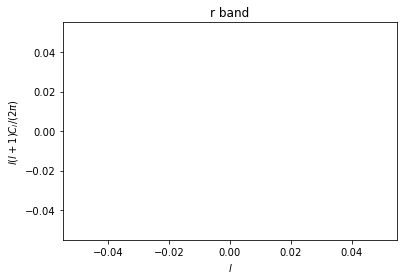

In [9]:
bgroup.plotAll(closefigs=False)

In [10]:
yearDates

[0, 365, 730, 1095, 1460]